In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import pickle
import re
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(base_path, "data")
sys.path.append(base_path)
print("Base Path:", base_path)
print("Data Path:", data_path)

Base Path: /root/geonhee/pausa_mitsloan
Data Path: /root/geonhee/pausa_mitsloan/data


In [4]:
import loader as io
import obso as obs
from trace_snapshot import TraceSnapshot

In [5]:
provider = "dfl" # "bepro" or "dfl"

# Load data: 30s
if provider == "bepro":
    bepro_data_dir = os.path.join(base_path, "data", "bepro", "elastic")
    game_id = 126476 #153373 #153373 #126476
    loader = io.ElasticLoader(bepro_data_dir, game_id)
elif provider == "dfl":
    # open DFL data: DFL-MAT-J03WMX, DFL-MAT-J03WR9, DFL-MAT-J03WN1, DFL-MAT-J03WOH, DFL-MAT-J03WOY, DFL-MAT-J03WPY, DFL-MAT-J03WQQ
    dfl_data_dir = os.path.join(base_path, "data", "dfl", "elastic")
    game_id = "DFL-MAT-J03WMX"
    loader = io.ElasticLoader(dfl_data_dir, game_id)
else:
    raise ValueError("Provider not supported.")

loader

## Event & Tracking Data Loading

In [6]:
raw_tracking_home = loader.get_trace_data("Home")
raw_tracking_home = loader.to_single_playing_direction(raw_tracking_home)
raw_tracking_home = loader.calc_player_velocities(raw_tracking_home)

x_cols = [col for col in raw_tracking_home.columns if re.match('Home_\d*_x', col)] + ["ball_x"]
y_cols = [col for col in raw_tracking_home.columns if re.match('Home_\d*_y', col)] + ["ball_y"]

tracking_home = raw_tracking_home.copy(deep=True)
tracking_home[x_cols] += 52.5
tracking_home[y_cols] += 34

tracking_home

,period_id,frame_id,Home_11_x,Home_14_x,Home_17_x,Home_2_x,Home_20_x,Home_24_x,Home_25_x,Home_27_x,...,Home_4_vx,Home_4_vy,Home_6_vx,Home_6_vy,Home_7_vx,Home_7_vy,Home_8_vx,Home_8_vy,ball_vx,ball_vy
0,1,10000,45.60,39.42,NaN,35.24,5.13,33.66,NaN,54.62,...,0.964286,-0.312500,7.142857e-01,-1.250000,0.169643,0.026786,NaN,NaN,14.541667,0.500000
1,1,10001,45.68,39.44,NaN,35.27,5.16,33.71,NaN,54.78,...,0.928571,-0.303571,7.142857e-01,-1.250000,0.196429,-0.017857,NaN,NaN,14.416667,0.500000
2,1,10002,45.78,39.45,NaN,35.32,5.20,33.75,NaN,54.94,...,0.892857,-0.294643,7.142857e-01,-1.250000,0.223214,-0.062500,NaN,NaN,14.333333,0.583333
3,1,10003,45.88,39.47,NaN,35.35,5.24,33.80,NaN,55.11,...,0.857143,-0.285714,7.142857e-01,-1.250000,0.250000,-0.107143,NaN,NaN,14.333333,0.583333
4,1,10004,46.00,39.48,NaN,35.39,5.28,33.85,NaN,55.28,...,0.857143,-0.321429,7.142857e-01,-1.285714,0.285714,-0.142857,NaN,NaN,14.333333,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85364,2,175122,NaN,57.89,39.35,NaN,5.36,32.38,65.83,NaN,...,-1.178571,0.678571,4.060224e-13,0.714286,0.250000,-0.750000,0.964286,-0.678571,7.750000,1.000000
85365,2,175123,NaN,57.88,39.35,NaN,5.39,32.43,65.80,NaN,...,-1.142857,0.642857,7.142857e-02,0.750000,0.250000,-0.750000,0.892857,-0.678571,7.416667,1.083333
85366,2,175124,NaN,57.88,39.35,NaN,5.42,32.49,65.76,NaN,...,-1.160714,0.633929,9.821429e-02,0.732143,0.250000,-0.750000,0.848214,-0.696429,7.250000,0.916667
85367,2,175125,NaN,57.89,39.35,NaN,5.47,32.54,65.72,NaN,...,-1.178571,0.625000,1.250000e-01,0.714286,0.250000,-0.750000,0.803571,-0.714286,7.083333,1.000000


In [7]:
raw_tracking_away = loader.get_trace_data("Away") # 1s
raw_tracking_away = loader.to_single_playing_direction(raw_tracking_away)
raw_tracking_away = loader.calc_player_velocities(raw_tracking_away)

x_cols = [col for col in raw_tracking_away.columns if re.match('Away_\d*_x', col)] + ['ball_x']
y_cols = [col for col in raw_tracking_away.columns if re.match('Away_\d*_y', col)] + ['ball_y']

tracking_away = raw_tracking_away.copy(deep=True)
tracking_away[x_cols] += 52.5
tracking_away[y_cols] += 34

tracking_away

,period_id,frame_id,Away_10_x,Away_11_x,Away_13_x,Away_2_x,Away_22_x,Away_25_x,Away_27_x,Away_38_x,...,Away_5_vx,Away_5_vy,Away_6_vx,Away_6_vy,Away_7_vx,Away_7_vy,Away_8_vx,Away_8_vy,ball_vx,ball_vy
0,1,10000,52.39,52.08,NaN,68.55,NaN,54.03,99.23,51.98,...,0.839286,0.223214,-0.794643,-0.196429,-1.794643,0.544643,NaN,NaN,14.541667,0.500000
1,1,10001,52.42,51.91,NaN,68.48,NaN,53.95,99.21,51.87,...,0.857143,0.196429,-0.803571,-0.250000,-1.910714,0.589286,NaN,NaN,14.416667,0.500000
2,1,10002,52.46,51.73,NaN,68.42,NaN,53.77,99.18,51.76,...,0.875000,0.169643,-0.812500,-0.303571,-2.026786,0.633929,NaN,NaN,14.333333,0.583333
3,1,10003,52.49,51.57,NaN,68.36,NaN,53.57,99.15,51.66,...,0.892857,0.142857,-0.821429,-0.357143,-2.142857,0.678571,NaN,NaN,14.333333,0.583333
4,1,10004,52.51,51.40,NaN,68.30,NaN,53.38,99.12,51.55,...,0.928571,0.142857,-0.821429,-0.392857,-2.250000,0.750000,NaN,NaN,14.333333,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85364,2,175122,46.20,NaN,38.87,61.36,62.69,NaN,91.74,NaN,...,1.250000,-0.964286,-0.214286,-1.321429,0.392857,-0.214286,-0.5,1.5,7.750000,1.000000
85365,2,175123,46.28,NaN,38.92,61.29,62.56,NaN,91.69,NaN,...,1.214286,-0.964286,-0.214286,-1.285714,0.392857,-0.214286,-0.5,1.5,7.416667,1.083333
85366,2,175124,46.37,NaN,38.97,61.24,62.41,NaN,91.65,NaN,...,1.205357,-0.955357,-0.223214,-1.250000,0.392857,-0.205357,-0.5,1.5,7.250000,0.916667
85367,2,175125,46.45,NaN,39.02,61.18,62.27,NaN,91.59,NaN,...,1.196429,-0.946429,-0.232143,-1.214286,0.392857,-0.196429,-0.5,1.5,7.083333,1.000000


In [8]:
overlap_cols = [col for col in tracking_home.columns if col in tracking_away.columns]
overlap_cols

['period_id',
 'frame_id',
 'ball_x',
 'ball_y',
 'time_seconds',
 'utc_timestamp',
 'ball_state',
 'ball_owning_team_id',
 'team',
 'ball_vx',
 'ball_vy']

In [9]:
traces = pd.concat(
            [tracking_home, tracking_away.drop(columns=overlap_cols)],
            axis=1
       )
traces = traces[sorted(traces.columns)]
traces.columns = traces.columns.str.replace('Home', 'H', regex=False)
traces.columns = traces.columns.str.replace('Away', 'A', regex=False)
traces.columns = traces.columns.str.replace('ball', 'B00', regex=False)
traces

,A_10_vx,A_10_vy,A_10_x,A_10_y,A_11_vx,A_11_vy,A_11_x,A_11_y,A_13_vx,A_13_vy,...,B00_state,B00_vx,B00_vy,B00_x,B00_y,frame_id,period_id,team,time_seconds,utc_timestamp
0,0.821429,-0.035714,52.39,55.87,-4.321429,0.955357,52.08,0.78,NaN,NaN,...,alive,14.541667,0.500000,52.32,34.17,10000,1,Away,0.00,2023-05-27 13:30:12.230
1,0.785714,-0.071429,52.42,55.87,-4.285714,0.982143,51.91,0.82,NaN,NaN,...,alive,14.416667,0.500000,52.90,34.19,10001,1,Away,0.04,2023-05-27 13:30:12.270
2,0.750000,-0.107143,52.46,55.86,-4.250000,1.008929,51.73,0.86,NaN,NaN,...,alive,14.333333,0.583333,53.47,34.21,10002,1,Away,0.08,2023-05-27 13:30:12.310
3,0.714286,-0.142857,52.49,55.85,-4.214286,1.035714,51.57,0.90,NaN,NaN,...,alive,14.333333,0.583333,54.04,34.24,10003,1,Away,0.12,2023-05-27 13:30:12.350
4,0.607143,-0.178571,52.51,55.85,-4.214286,1.000000,51.40,0.94,NaN,NaN,...,alive,14.333333,0.583333,54.62,34.26,10004,1,Away,0.16,2023-05-27 13:30:12.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85364,2.214286,-0.285714,46.20,52.74,0.000000,0.000000,NaN,NaN,1.25,-1.285714,...,alive,7.750000,1.000000,56.30,45.69,175122,2,Home,3004.88,2023-05-27 15:25:48.270
85365,2.178571,-0.250000,46.28,52.73,0.000000,0.000000,NaN,NaN,1.25,-1.357143,...,alive,7.416667,1.083333,56.60,45.72,175123,2,Home,3004.92,2023-05-27 15:25:48.310
85366,2.107143,-0.196429,46.37,52.72,0.000000,0.000000,NaN,NaN,1.25,-1.410714,...,alive,7.250000,0.916667,56.88,45.77,175124,2,Home,3004.96,2023-05-27 15:25:48.350
85367,2.035714,-0.142857,46.45,52.71,0.000000,0.000000,NaN,NaN,1.25,-1.464286,...,alive,7.083333,1.000000,57.17,45.80,175125,2,Home,3005.00,2023-05-27 15:25:48.390


In [10]:
events = loader.get_event_data()
events = loader.to_single_playing_direction(events)
events

/root/geonhee/pausa_mitsloan/loader.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  event_df = pd.concat([event_df, receive_event_df], ignore_index=True)


,game_id,period_id,frame_id,receive_frame_id,prev_receive_frame_id,team_id,team,player_id,player_name,player_code,receiver_code,spadl_type,success,start_x,start_y
0,DFL-MAT-J03WMX,1,10000.0,10025.0,NaN,DFL-CLU-00000G,Away,DFL-OBJ-0027G6,Serge Gnabry,Away_7,Away_2,pass,True,0.00,0.00
1,DFL-MAT-J03WMX,1,10025.0,NaN,NaN,DFL-CLU-00000G,Away,DFL-OBJ-0027KL,Dayot Upamecano,Away_2,None,receive,True,15.26,-0.03
2,DFL-MAT-J03WMX,1,10040.0,10131.0,10025.0,DFL-CLU-00000G,Away,DFL-OBJ-0027KL,Dayot Upamecano,Away_2,Out,pass,False,14.23,0.20
3,DFL-MAT-J03WMX,1,10415.0,10512.0,NaN,DFL-CLU-000008,Home,DFL-OBJ-0002BO,B. Schmitz,Home_2,Away_2,throw_in,False,-27.15,-34.00
4,DFL-MAT-J03WMX,1,10512.0,NaN,NaN,DFL-CLU-00000G,Away,DFL-OBJ-0027KL,Dayot Upamecano,Away_2,None,receive,False,2.40,-24.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274,DFL-MAT-J03WMX,2,174720.0,NaN,NaN,DFL-CLU-000008,Home,DFL-OBJ-00012X,Jonas Hector,Home_14,None,receive,True,-14.39,30.51
2275,DFL-MAT-J03WMX,2,174724.0,174769.0,174720.0,DFL-CLU-000008,Home,DFL-OBJ-00012X,Jonas Hector,Home_14,Away_2,pass,False,-14.13,30.99
2276,DFL-MAT-J03WMX,2,174769.0,NaN,NaN,DFL-CLU-00000G,Away,DFL-OBJ-0027KL,Dayot Upamecano,Away_2,None,receive,False,1.71,28.22
2277,DFL-MAT-J03WMX,2,174769.0,NaN,NaN,DFL-CLU-00000G,Away,DFL-OBJ-0027KL,Dayot Upamecano,Away_2,None,interception,True,2.60,28.28


In [11]:
events_df = loader.convert_common_format_for_event(events, raw_tracking_home, raw_tracking_away)
events_df = loader.check_home_away_event(events_df, raw_tracking_home, raw_tracking_away)
#events_df['event_zone'] = obs.check_event_zone(events_df, raw_tracking_home, raw_tracking_away)['zone']

x_cols = ["start_x", "end_x"]
y_cols = ["start_y", "end_y"]

events_df[x_cols] += 52.5
events_df[y_cols] += 34

events_df

Team Name OK: kickoff=Away, event first team= Away


,game_id,period_id,receive_frame,start_frame,end_frame,start_time_seconds,end_time_seconds,player_name,player_code,receiver_code,team,receiver_team,type_name,result_name,start_x,start_y,end_x,end_y
0,DFL-MAT-J03WMX,1,NaN,10000.0,10025.0,0.00,1.00,Serge Gnabry,Away_7,Away_2,Away,Away,pass,True,52.50,34.00,67.76,33.97
1,DFL-MAT-J03WMX,1,NaN,10025.0,NaN,1.00,NaN,Dayot Upamecano,Away_2,None,Away,None,receive,True,67.76,33.97,NaN,NaN
2,DFL-MAT-J03WMX,1,10025.0,10040.0,10131.0,1.60,5.24,Dayot Upamecano,Away_2,Out,Away,Out,pass,False,66.73,34.20,NaN,NaN
3,DFL-MAT-J03WMX,1,NaN,10415.0,10512.0,16.60,20.48,B. Schmitz,Home_2,Away_2,Home,Away,throw_in,False,25.35,0.00,54.90,9.69
4,DFL-MAT-J03WMX,1,NaN,10512.0,NaN,20.48,NaN,Dayot Upamecano,Away_2,None,Away,None,receive,False,54.90,9.69,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274,DFL-MAT-J03WMX,2,NaN,174720.0,NaN,2988.80,NaN,Jonas Hector,Home_14,None,Home,None,receive,True,38.11,64.51,NaN,NaN
2275,DFL-MAT-J03WMX,2,174720.0,174724.0,174769.0,2988.96,2990.76,Jonas Hector,Home_14,Away_2,Home,Away,pass,False,38.37,64.99,54.21,62.22
2276,DFL-MAT-J03WMX,2,NaN,174769.0,NaN,2990.76,NaN,Dayot Upamecano,Away_2,None,Away,None,receive,False,54.21,62.22,NaN,NaN
2277,DFL-MAT-J03WMX,2,NaN,174769.0,NaN,2990.76,NaN,Dayot Upamecano,Away_2,None,Away,None,interception,True,55.10,62.28,NaN,NaN


## OBSO output loading

1. OBSO
2. EPV
3. Pitch Control
4. Transition

In [12]:
event_obso_dir = os.path.join(base_path, "data", provider, "obso", str(game_id), "event")
with open(os.path.join(event_obso_dir, "obso.pkl"), "rb") as f:
    event_obso = pickle.load(f)

event_obso

,event_number,event_frame,period_id,team,ball_x,ball_y,obso_map,ppcf_map,trans_map,score_map
0,0,10000.0,1,Away,0.00,0.00,"[[6.84666936097714e-12, 4.731429316985381e-11,...","[[2.194509836887326e-06, 9.132878843412998e-06...","[[4.0241886642422395e-05, 6.981665535967451e-0...","[[0.07752887644382218, 0.07420371018550927, 0...."
1,1,10025.0,1,Away,15.26,-0.03,"[[4.5069256290752765e-12, 3.326391854456394e-1...","[[0.00018522175833853285, 0.000685144139876611...","[[3.138519987263543e-07, 6.542833075264662e-07...","[[0.07752887644382218, 0.07420371018550927, 0...."
2,2,10040.0,1,Away,14.23,0.20,"[[9.247058675406649e-11, 4.780025896636978e-10...","[[0.002666782262236144, 0.0070693771412481945,...","[[4.47252282260207e-07, 9.11220491674024e-07, ...","[[0.07752887644382218, 0.07420371018550927, 0...."
3,3,10415.0,1,Home,-27.15,-34.00,"[[0.0011394303810761683, 0.0015091689440558781...","[[0.8482668491796993, 0.852986595300519, 0.856...","[[0.1668544157384806, 0.21977488310014048, 0.2...","[[0.008050402520126006, 0.008050402520126006, ..."
4,4,10512.0,1,Away,2.40,-24.31,"[[2.744335563611681e-07, 1.3488161724181597e-0...","[[0.014181179355434342, 0.040090826087892516, ...","[[0.0002496096513661414, 0.000453400650453422,...","[[0.07752887644382218, 0.07420371018550927, 0...."
...,...,...,...,...,...,...,...,...,...,...
2274,1019,174720.0,2,Home,-14.39,30.51,"[[2.5086019562946344e-09, 3.7922091897299925e-...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9826686...","[[3.116119908319031e-07, 4.710583328286343e-07...","[[0.008050402520126006, 0.008050402520126006, ..."
2275,1020,174724.0,2,Home,-14.13,30.99,"[[2.5086019562946344e-09, 3.7922091897299925e-...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98...","[[3.116119908319031e-07, 4.710583328286343e-07...","[[0.008050402520126006, 0.008050402520126006, ..."
2276,1021,174769.0,2,Away,1.71,28.22,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.69...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.27...","[[1.8535509134403827e-08, 3.290449693885925e-0...","[[0.07752887644382218, 0.07420371018550927, 0...."
2277,1022,174769.0,2,Away,2.60,28.28,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.42...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.26...","[[1.0204312605872109e-08, 1.8535509134403827e-...","[[0.07752887644382218, 0.07420371018550927, 0...."


In [13]:
trace_obso_dir = os.path.join(base_path, "data", provider, "obso", str(game_id), "trace")
with open(os.path.join(trace_obso_dir, "obso.pkl"), "rb") as f:
    trace_obso = pickle.load(f)   
trace_obso

,trace_number,trace_frame,period_id,team,ball_x,ball_y,obso_map,ppcf_map,trans_map,score_map
0,0,10000,1,Away,-0.18,0.17,"[[6.835716260023221e-12, 4.724530215526888e-11...","[[2.19099912437581e-06, 9.119561798281913e-06,...","[[4.0241886642422395e-05, 6.981665535967451e-0...","[[0.07752887644382218, 0.07420371018550927, 0...."
1,1,10001,1,Away,0.40,0.19,"[[4.38711685351627e-12, 3.0959173130397834e-11...","[[2.4962502100958364e-06, 1.0367771068738646e-...","[[2.2668751290507427e-05, 4.0241886642422395e-...","[[0.07752887644382218, 0.07420371018550927, 0...."
2,2,10002,1,Away,0.97,0.21,"[[5.1666291328602224e-12, 3.63704584673887e-11...","[[2.939789271410108e-06, 1.2179930822658487e-0...","[[2.2668751290507427e-05, 4.0241886642422395e-...","[[0.07752887644382218, 0.07420371018550927, 0...."
3,3,10003,1,Away,1.54,0.24,"[[5.894960355482623e-12, 4.136847123203723e-11...","[[3.3542065363692856e-06, 1.3853691679392443e-...","[[2.2668751290507427e-05, 4.0241886642422395e-...","[[0.07752887644382218, 0.07420371018550927, 0...."
4,4,10004,1,Away,2.12,0.26,"[[3.781668550374238e-12, 2.7094384446565585e-1...","[[3.9085272047155446e-06, 1.6107423247456868e-...","[[1.247977721441449e-05, 2.2668751290507427e-0...","[[0.07752887644382218, 0.07420371018550927, 0...."
...,...,...,...,...,...,...,...,...,...,...
85364,38139,175122,2,Home,3.80,11.69,"[[1.0290960844435567e-08, 1.8740799945918086e-...","[[0.9803594023068998, 0.9828715225951403, 0.98...","[[1.3039262000272017e-06, 2.3685021152022105e-...","[[0.008050402520126006, 0.008050402520126006, ..."
85365,38140,175123,2,Home,4.10,11.72,"[[1.0308358880725794e-08, 1.8706301905147844e-...","[[0.9820168110480889, 0.9810622539429887, 0.97...","[[1.3039262000272017e-06, 2.3685021152022105e-...","[[0.008050402520126006, 0.008050402520126006, ..."
85366,38141,175124,2,Home,4.38,11.77,"[[5.535771700012723e-09, 1.0316214351741176e-0...","[[0.9801631216917959, 0.9827651556376654, 0.98...","[[7.015557963914475e-07, 1.3039262000272017e-0...","[[0.008050402520126006, 0.008050402520126006, ..."
85367,38142,175125,2,Home,4.67,11.80,"[[5.546581915218418e-09, 1.0300246245235431e-0...","[[0.982077177194148, 0.9812439679092709, 0.980...","[[7.015557963914475e-07, 1.3039262000272017e-0...","[[0.008050402520126006, 0.008050402520126006, ..."


### Visualization

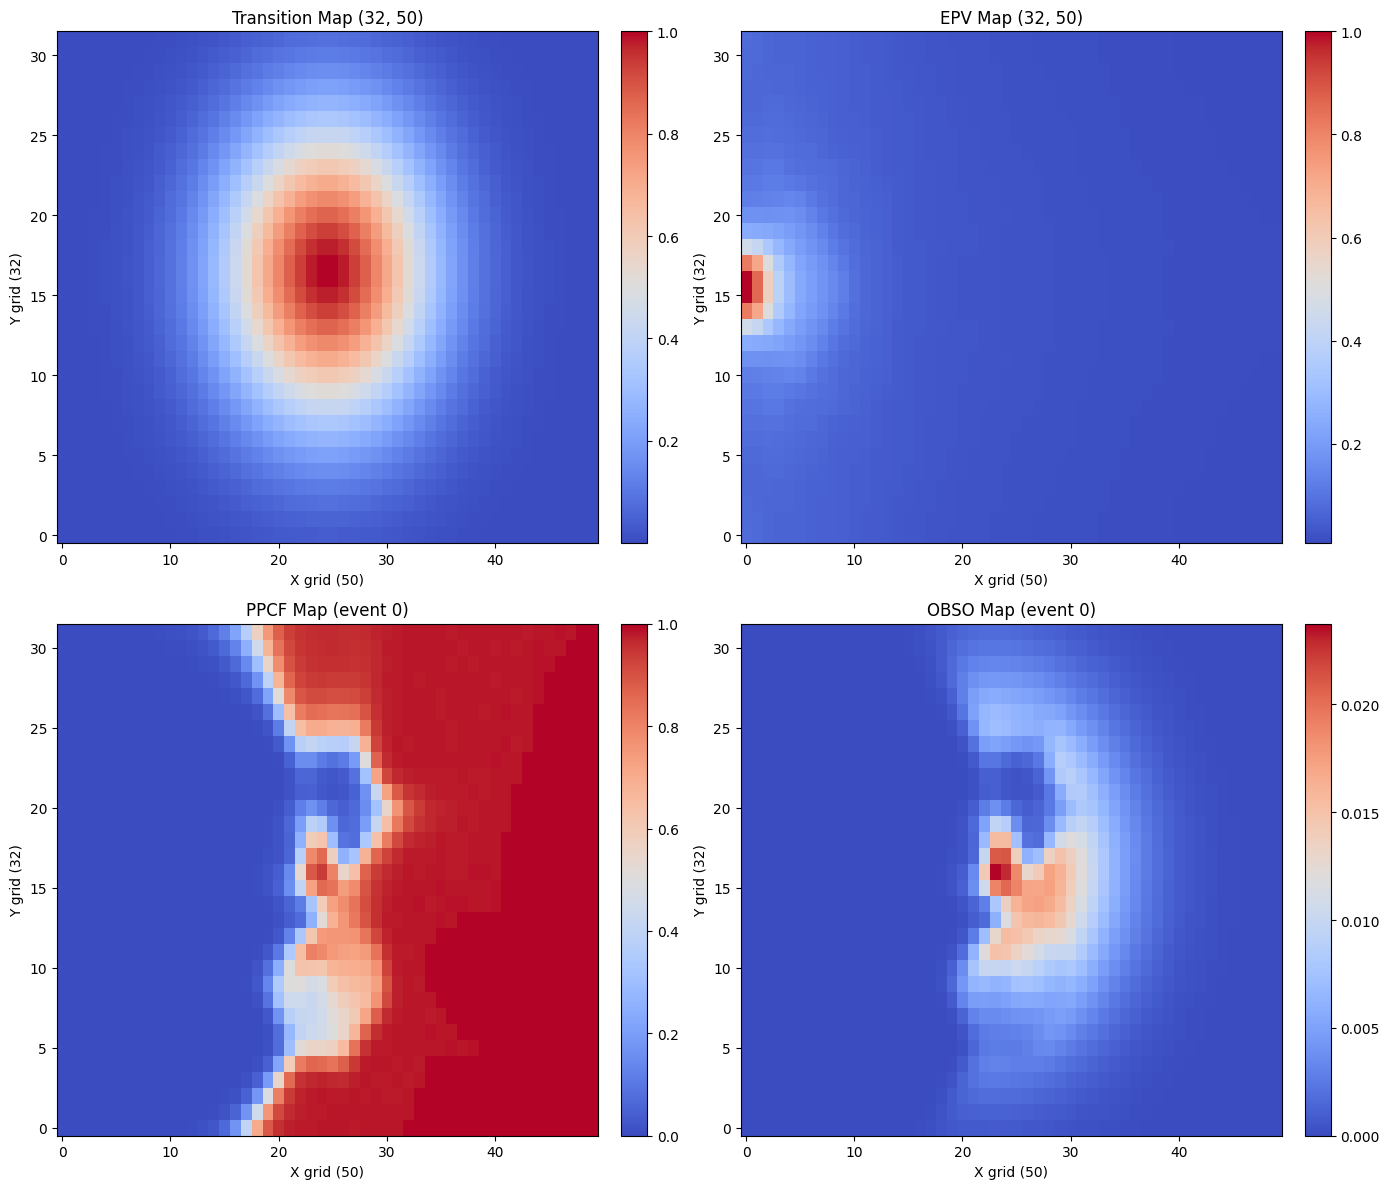

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

obs_idx = 0 
trans_map = event_obso.at[obs_idx, "trans_map"]
score_map = event_obso.at[obs_idx, "score_map"]
ppcf_map = event_obso.at[obs_idx, "ppcf_map"]
obso_map = event_obso.at[obs_idx, "obso_map"]

# ----- 1. Transition -----
im1 = axes[0, 0].imshow(
    trans_map,
    cmap='coolwarm', origin='lower', aspect='auto'
)
axes[0, 0].set_title(f"Transition Map {trans_map.shape}")
axes[0, 0].set_xlabel(f"X grid ({trans_map.shape[1]})")
axes[0, 0].set_ylabel(f"Y grid ({trans_map.shape[0]})")
fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)

# ----- 2. EPV -----
im2 = axes[0, 1].imshow(
    score_map,
    cmap='coolwarm', origin='lower', aspect='auto'
)
axes[0, 1].set_title(f"EPV Map {score_map.shape}")
axes[0, 1].set_xlabel(f"X grid ({score_map.shape[1]})")
axes[0, 1].set_ylabel(f"Y grid ({score_map.shape[0]})")
fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)

# ----- 3. PPCF -----
im3 = axes[1, 0].imshow(
    ppcf_map    ,
    cmap='coolwarm', origin='lower', aspect='auto'
)
axes[1, 0].set_title(f"PPCF Map (event {obs_idx})")
axes[1, 0].set_xlabel(f"X grid ({ppcf_map.shape[1]})")
axes[1, 0].set_ylabel(f"Y grid ({ppcf_map.shape[0]})")
fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

# ----- 4. OBSO -----
im4 = axes[1, 1].imshow(
    obso_map,
    cmap='coolwarm', origin='lower', aspect='auto'
)
axes[1, 1].set_title(f"OBSO Map (event {obs_idx})")
axes[1, 1].set_xlabel(f"X grid ({obso_map.shape[1]})")
axes[1, 1].set_ylabel(f"Y grid ({obso_map.shape[0]})")
fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### OBSO based on Event data

In [15]:
pd.concat([events_df.groupby("period_id").head(1), events_df.groupby("period_id").tail(1)]).sort_index()

,game_id,period_id,receive_frame,start_frame,end_frame,start_time_seconds,end_time_seconds,player_name,player_code,receiver_code,team,receiver_team,type_name,result_name,start_x,start_y,end_x,end_y
0,DFL-MAT-J03WMX,1,NaN,10000.0,10025.0,0.00,1.00,Serge Gnabry,Away_7,Away_2,Away,Away,pass,True,52.50,34.00,67.76,33.97
1254,DFL-MAT-J03WMX,1,NaN,80472.0,NaN,2818.88,NaN,B. Schmitz,Home_2,None,Home,None,bad_touch,False,30.56,4.31,NaN,NaN
1255,DFL-MAT-J03WMX,2,NaN,100000.0,100038.0,0.00,1.52,F. Kainz,Home_11,Home_4,Home,Home,pass,True,52.50,34.00,26.45,31.56
2278,DFL-MAT-J03WMX,2,NaN,175038.0,175126.0,3001.52,3005.04,M. Schwäbe,Home_20,None,Home,None,goalkick,False,3.21,38.21,NaN,NaN


Frame: 43680.0 ~ 43682.0


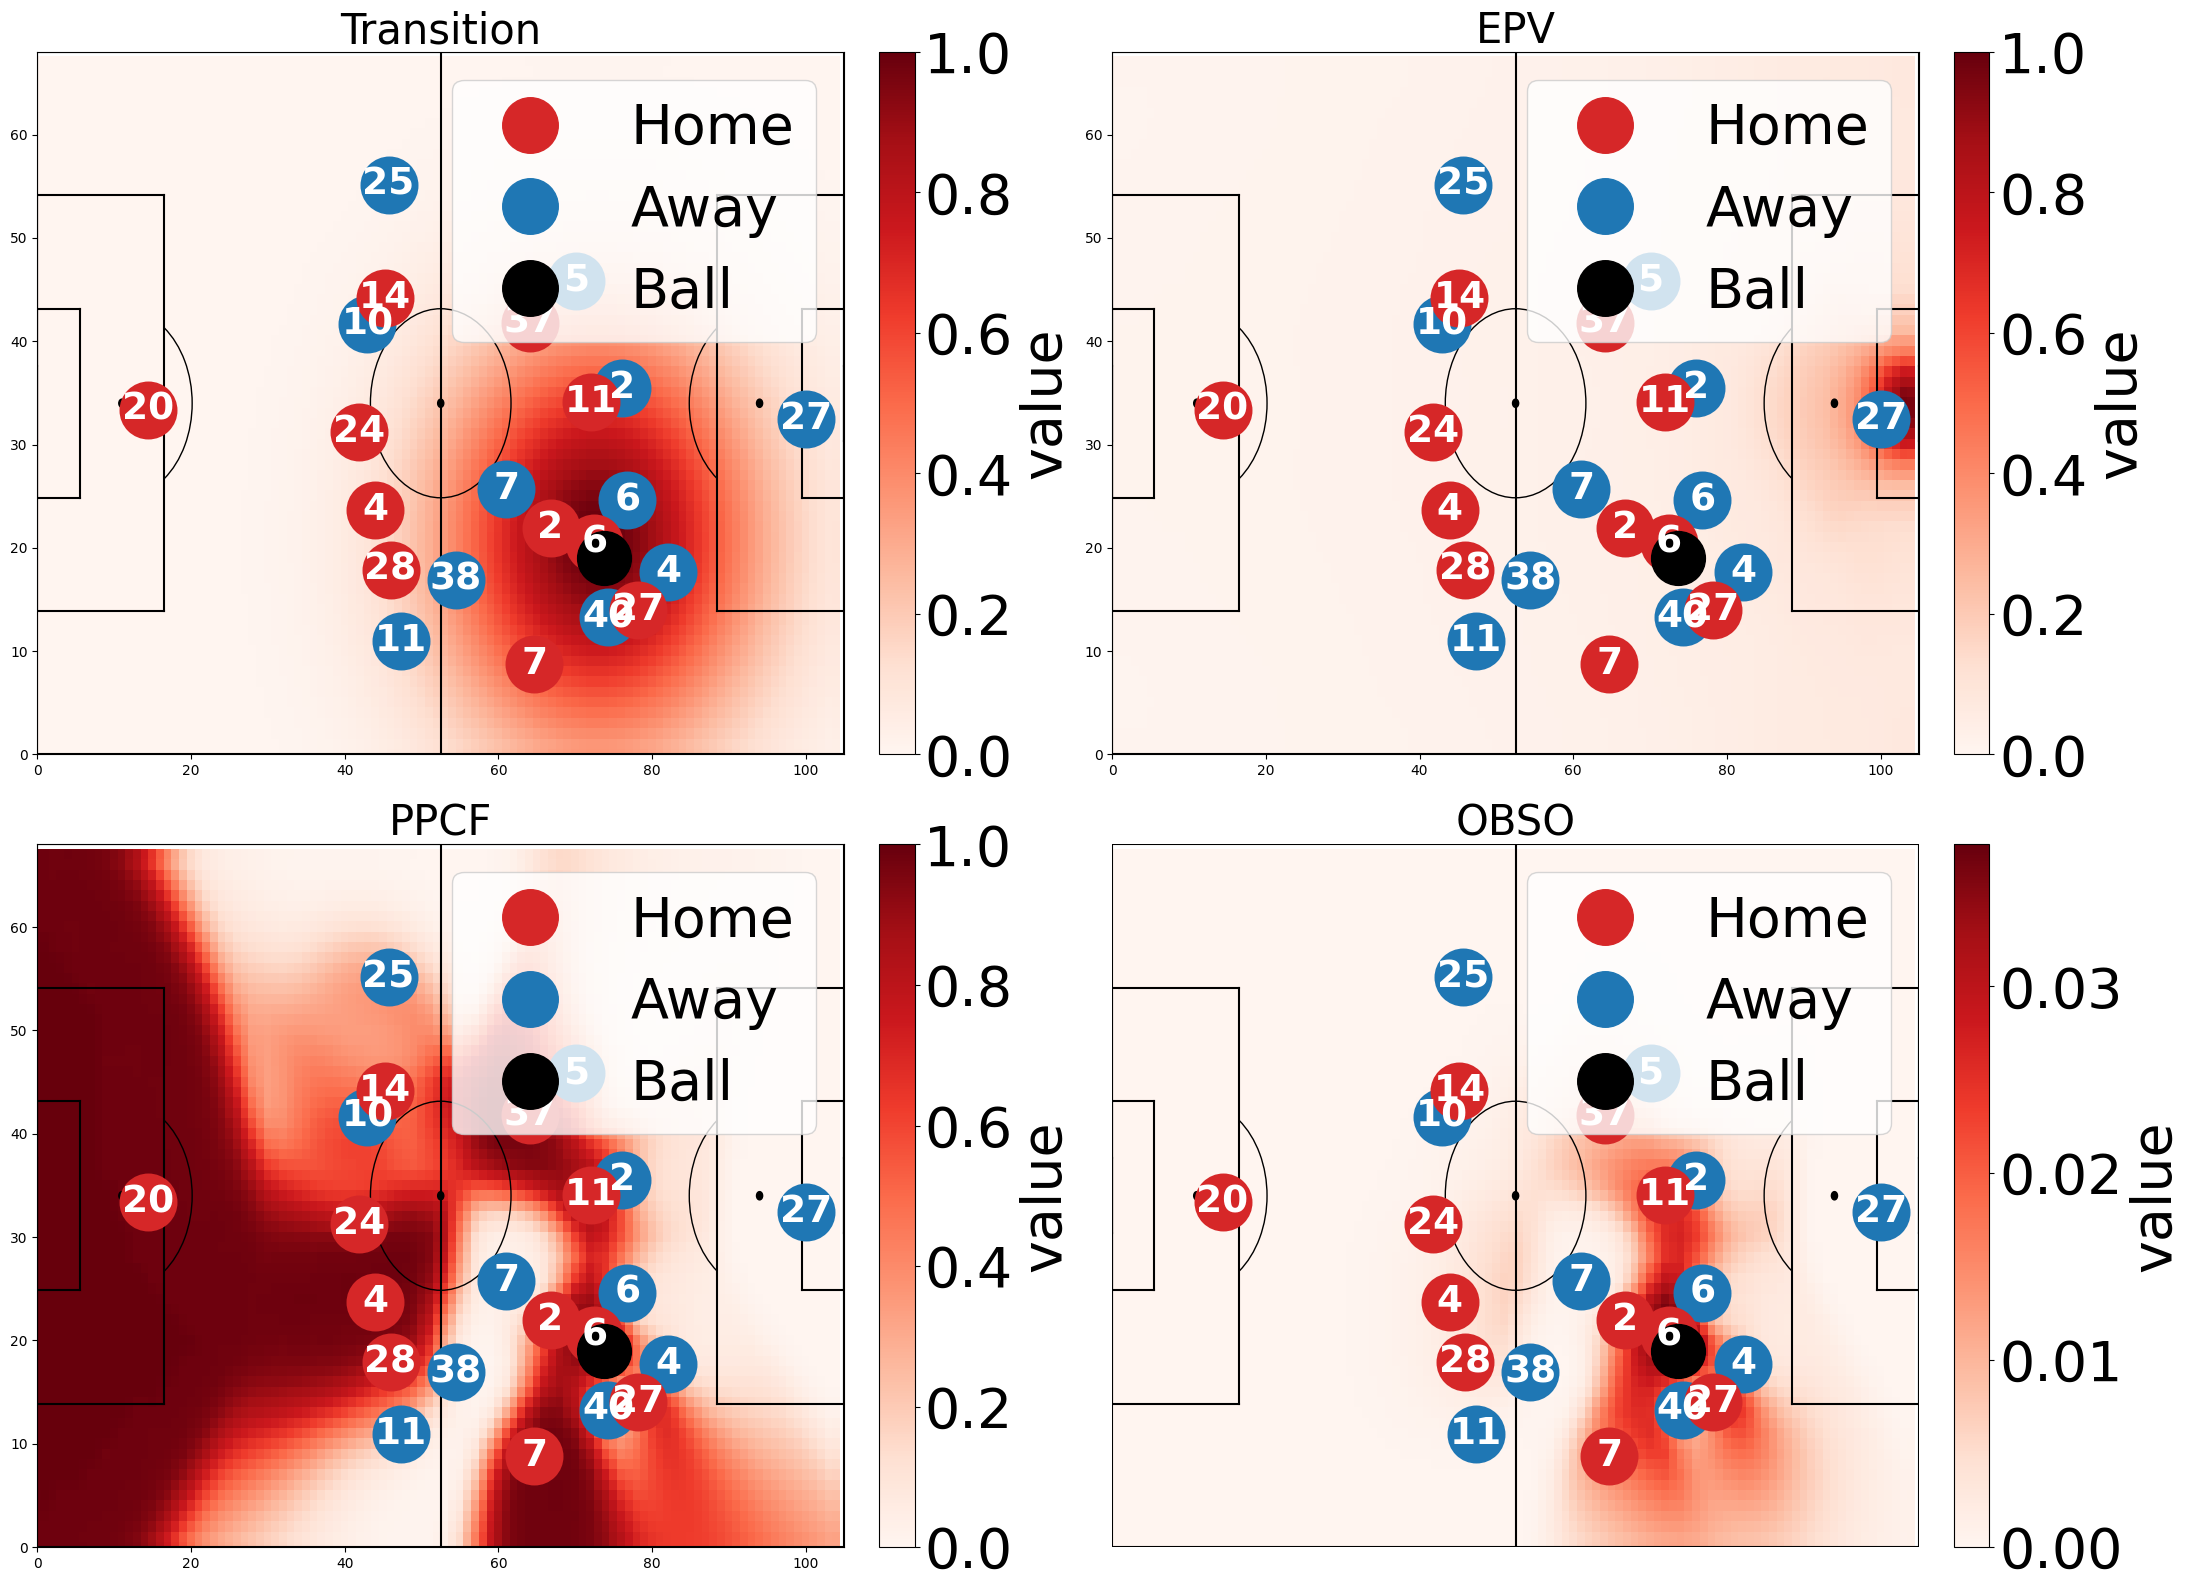

,game_id,period_id,receive_frame,start_frame,end_frame,start_time_seconds,end_time_seconds,player_name,player_code,receiver_code,team,receiver_team,type_name,result_name,start_x,start_y,end_x,end_y
692,DFL-MAT-J03WMX,1,43604.0,43681.0,43696.0,1347.24,1347.84,E. Martel,Home_6,Home_27,Home,Home,pass,True,73.44,20.06,80.33,14.59


In [16]:
event_num = 692
before_margin = 1
after_margin = 1

highlight = events_df.loc[event_num]
trace = traces[
    (traces["period_id"] == highlight.period_id) & 
    (traces["frame_id"] >= highlight.start_frame - before_margin) & 
    (traces["frame_id"] <= highlight.start_frame + after_margin)
]
print(f"Frame: {highlight.start_frame - before_margin} ~ {highlight.start_frame + after_margin}")

snapshot = TraceSnapshot(trace, play_left_to_right=False)
maps = [
    ("Transition", event_obso.at[event_num, "trans_map"]),
    ("EPV", event_obso.at[event_num, "score_map"]),
    ("PPCF", event_obso.at[event_num, "ppcf_map"]),
    ("OBSO", event_obso.at[event_num, "obso_map"]),
]

fig, axes = plt.subplots(2, 2, figsize=(22, 16))
axes = axes.flatten()

for ax, (title, value) in zip(axes, maps):
    snapshot.plot(
        ax=ax,
        obso=value,
        vmin=0,
        vmax=np.max(value),
        color="white"
    )
    ax.set_title(title, fontsize=30)

plt.tight_layout()
plt.show()
pd.DataFrame([highlight])

### OBSO based on Tracking data

animation_obso_dir: /root/geonhee/pausa_mitsloan/data/dfl/obso/DFL-MAT-J03WMX/animation
output_obso_dir: /root/geonhee/pausa_mitsloan/data/dfl/obso/DFL-MAT-J03WMX/animation/output
Frame: 43606.0 ~ 43706.0


  0%|          | 0/101 [00:00<?, ?it/s]

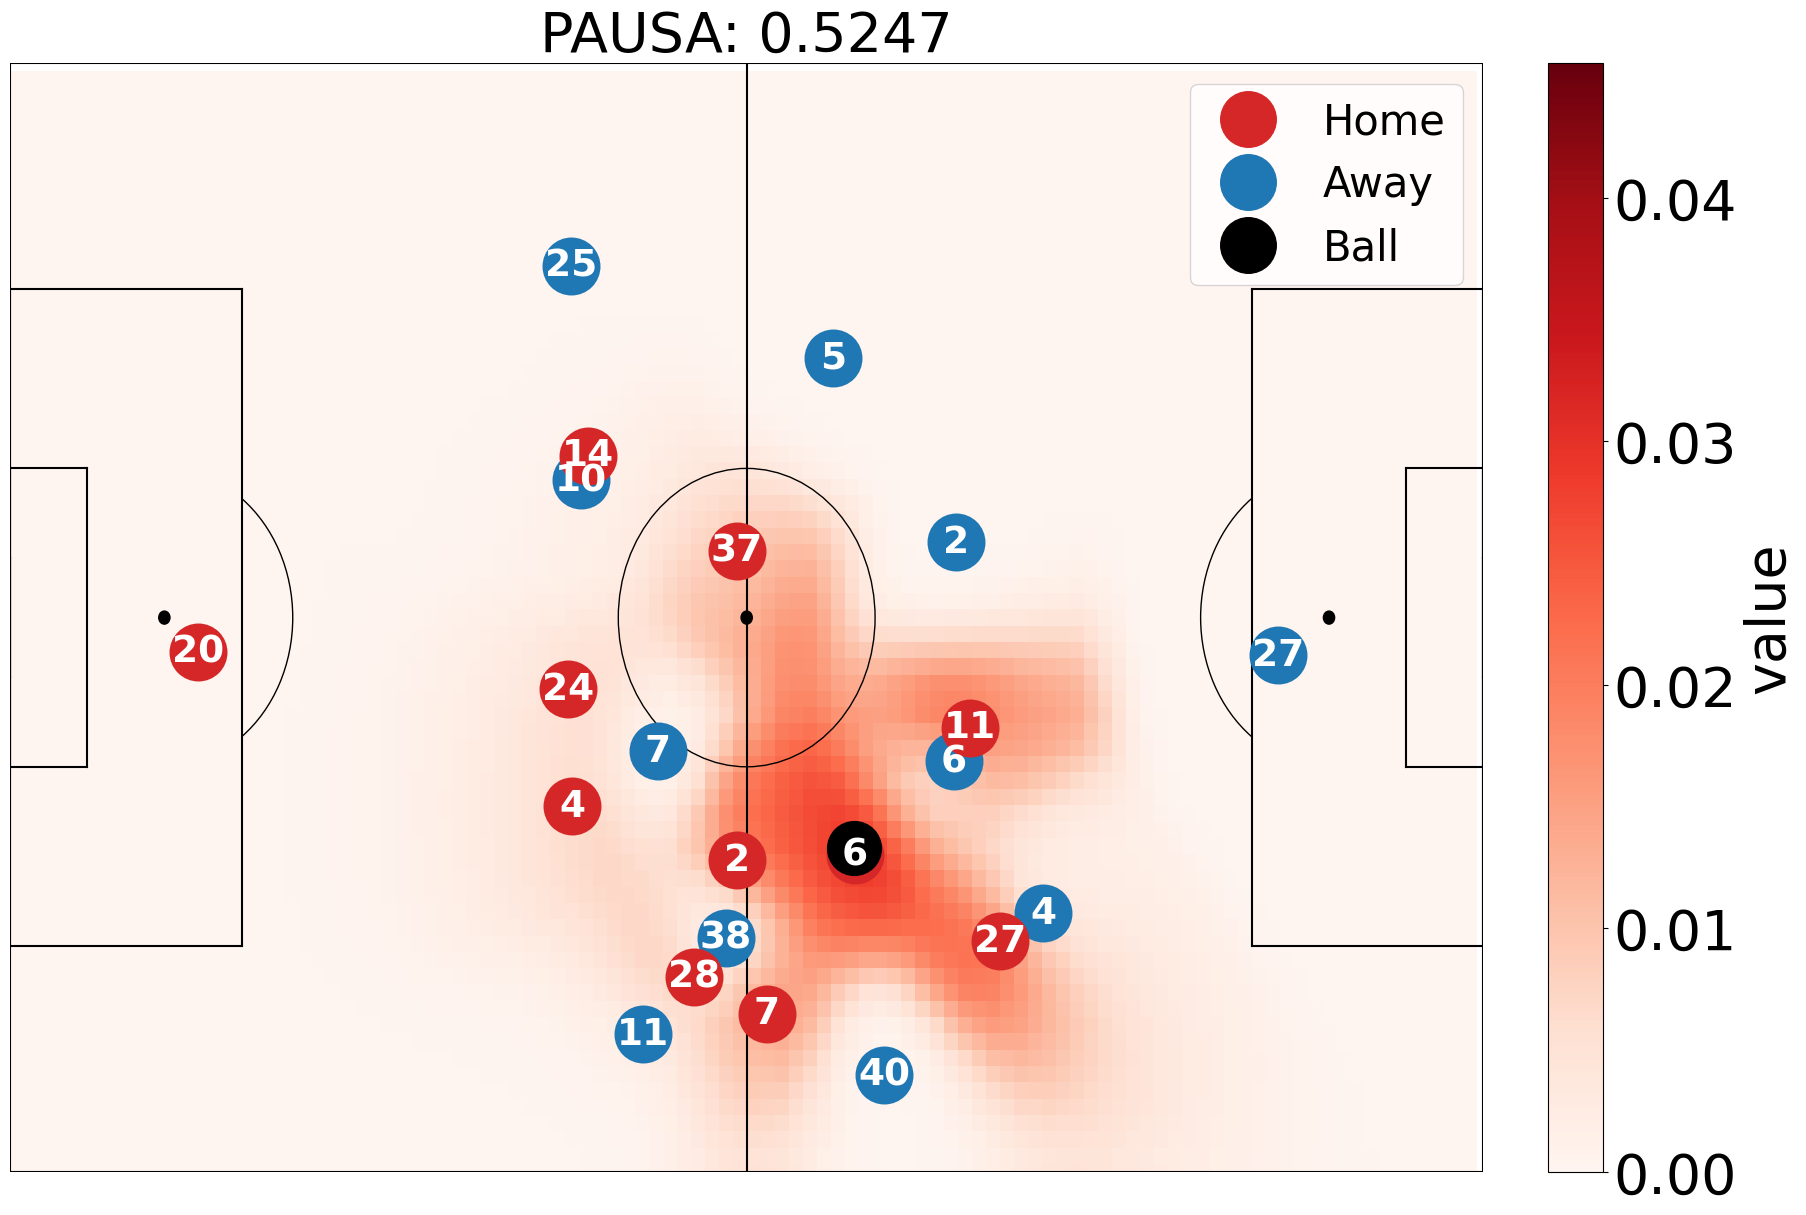

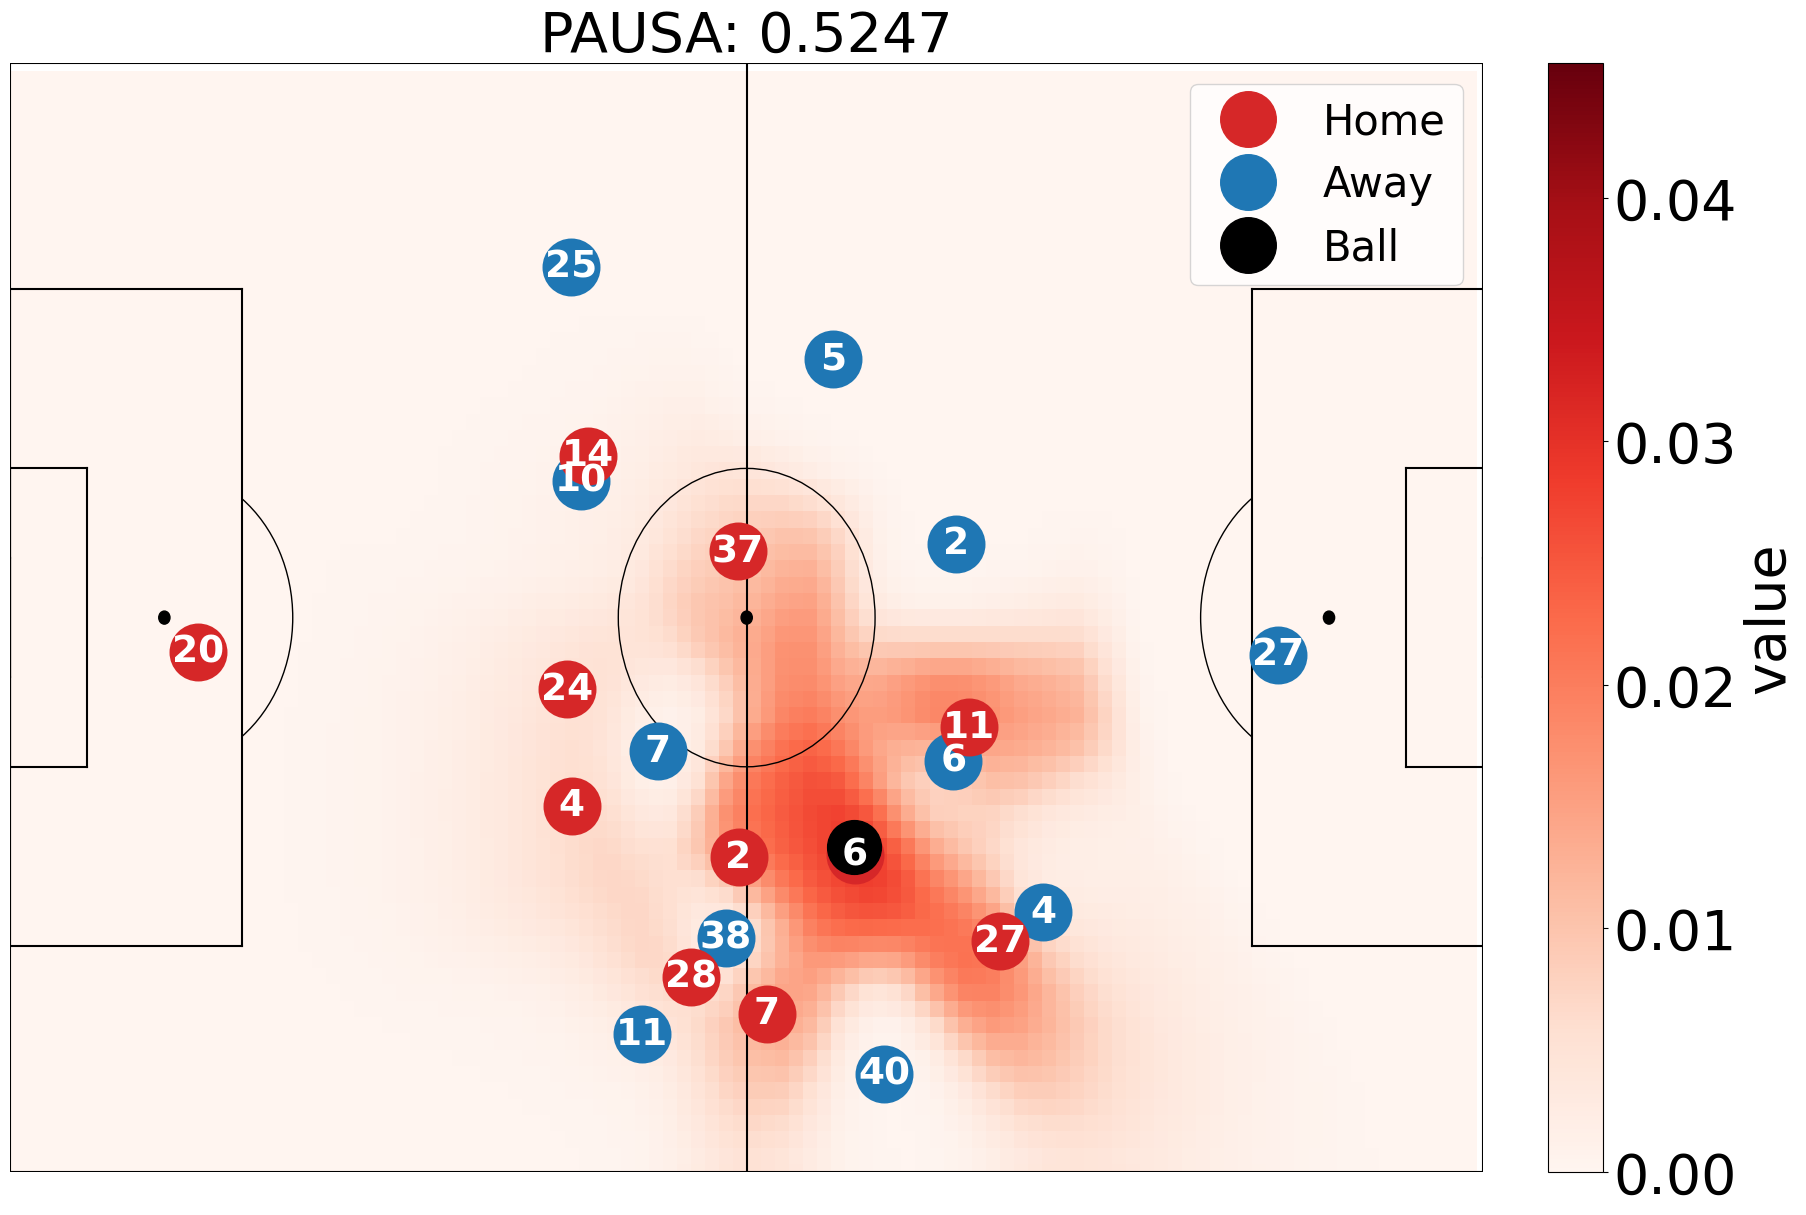

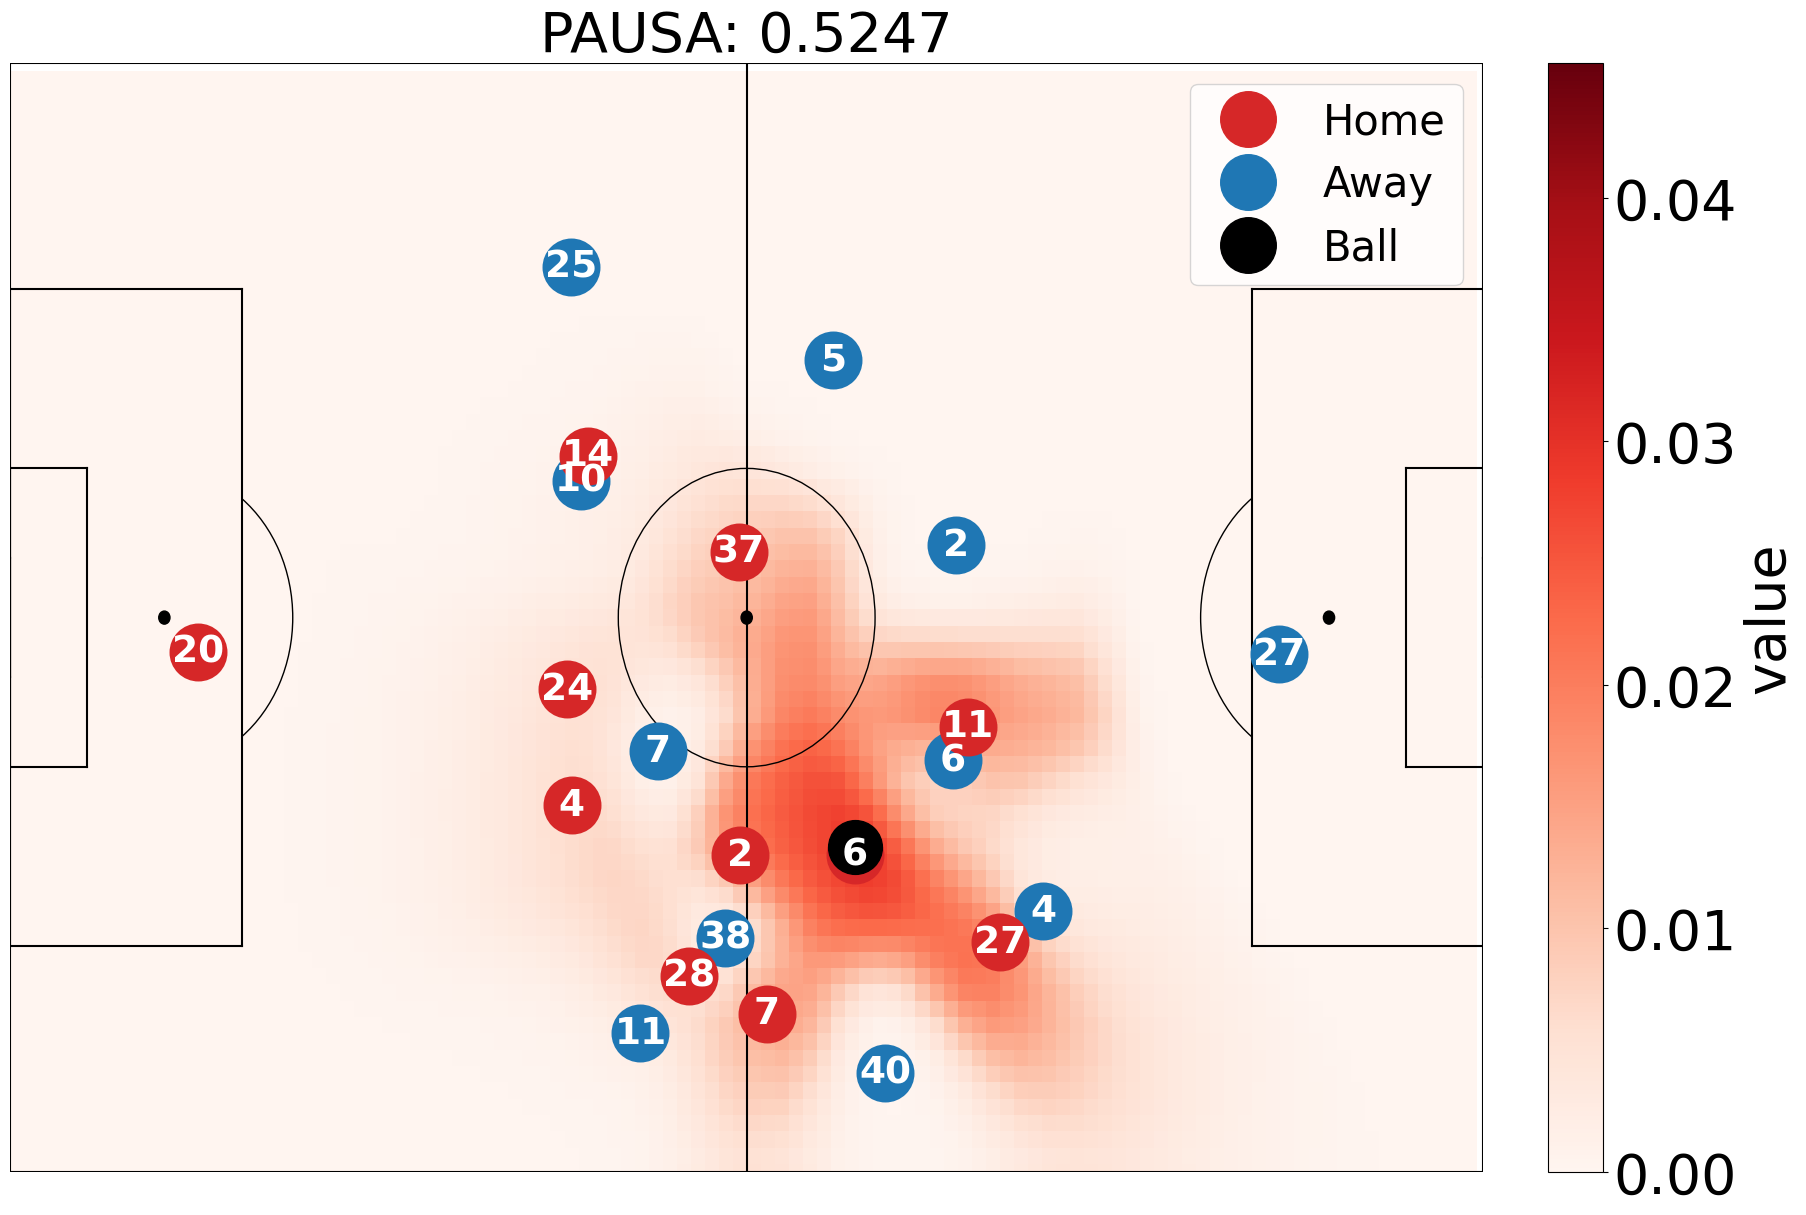

,A_10_vx,A_10_vy,A_10_x,A_10_y,A_11_vx,A_11_vy,A_11_x,A_11_y,A_13_vx,A_13_vy,...,B00_state,B00_vx,B00_vy,B00_x,B00_y,frame_id,period_id,team,time_seconds,utc_timestamp
25036,-0.500000,-0.714286,40.70,42.42,-2.178571,0.500000,45.10,8.46,NaN,NaN,...,alive,3.500000,1.666667,60.13,19.88,43606,1,Home,1344.24,2023-05-27 13:52:36.470
25037,-0.500000,-0.678571,40.68,42.40,-2.107143,0.500000,45.01,8.48,NaN,NaN,...,alive,1.416667,0.833333,60.18,19.92,43607,1,Home,1344.28,2023-05-27 13:52:36.510
25038,-0.500000,-0.642857,40.66,42.37,-2.035714,0.535714,44.93,8.51,NaN,NaN,...,alive,1.500000,1.000000,60.24,19.95,43608,1,Home,1344.32,2023-05-27 13:52:36.550
25039,-0.500000,-0.642857,40.63,42.34,-2.035714,0.571429,44.85,8.53,NaN,NaN,...,alive,1.750000,0.916667,60.31,20.00,43609,1,Home,1344.36,2023-05-27 13:52:36.590
25040,-0.500000,-0.607143,40.61,42.32,-1.964286,0.607143,44.77,8.55,NaN,NaN,...,alive,1.916667,1.333333,60.39,20.03,43610,1,Home,1344.40,2023-05-27 13:52:36.630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25132,1.464286,0.178571,44.11,41.74,3.678571,0.285714,50.28,11.33,NaN,NaN,...,alive,4.916667,1.333333,81.37,15.38,43702,1,Home,1348.08,2023-05-27 13:52:40.310
25133,1.464286,0.214286,44.16,41.74,3.678571,0.285714,50.42,11.35,NaN,NaN,...,alive,4.500000,1.166667,81.64,15.41,43703,1,Home,1348.12,2023-05-27 13:52:40.350
25134,1.500000,0.250000,44.23,41.75,3.678571,0.250000,50.57,11.36,NaN,NaN,...,alive,4.583333,1.250000,81.77,15.47,43704,1,Home,1348.16,2023-05-27 13:52:40.390
25135,1.464286,0.250000,44.29,41.76,3.714286,0.285714,50.71,11.37,NaN,NaN,...,alive,-0.833333,-1.250000,81.92,15.53,43705,1,Home,1348.20,2023-05-27 13:52:40.430


In [26]:
animation_obso_dir = os.path.join(base_path, "data", provider, "obso", str(game_id), "animation")
output_obso_dir = os.path.join(animation_obso_dir, "output")
os.makedirs(animation_obso_dir, exist_ok=True)
os.makedirs(output_obso_dir, exist_ok=True)
print(f"animation_obso_dir: {animation_obso_dir}")
print(f"output_obso_dir: {output_obso_dir}")

trace = traces[
    (traces["period_id"] == highlight.period_id) & 
    (traces["frame_id"] >= highlight.start_frame - 75) & 
    (traces["frame_id"] <= highlight.start_frame + 25)
]
print(f"Frame: {highlight.start_frame - 75} ~ {highlight.start_frame + 25}")

values = trace_obso[trace_obso["trace_frame"].isin(trace["frame_id"].values)].obso_map.values
max_value = np.max(np.stack(values))

for trace_num, row in tqdm(enumerate(trace.itertuples()), total=len(trace)):
    obso = trace_obso[trace_obso["trace_frame"] == row.frame_id]
    if obso.empty:
        obso = None
    else:
        obso = obso.obso_map.values[0]
 
    snapshot = TraceSnapshot(traces[traces["frame_id"] == row.frame_id], play_left_to_right=False)
    fig, ax = snapshot.plot(color="white", obso=obso, vmin=0, vmax=max_value)

    if trace_num < 3: # show first 3 frames
        plt.show()
    else:
        plt.close(fig)
  
    save_path = os.path.join(output_obso_dir, f"frame_{row.frame_id:03d}.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

trace

In [27]:
frame_paths = sorted(glob.glob(os.path.join(output_obso_dir, "frame_*.png")))

frames = [plt.imread(fp) for fp in frame_paths]
print(f"Total frames: {len(frames)}")
h, w, _ = frames[0].shape

# Ensure width/height are even
if w % 2 != 0:
    w += 1
if h % 2 != 0:
    h += 1

# Adjust figsize to match even pixel dimensions
fig = plt.figure(figsize=(w / 100, h / 100), dpi=100)
ax = fig.add_subplot(111)

ax.axis("off")
im = ax.imshow(frames[0])

def update(i):
    im.set_array(frames[i])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

ani.save(
    os.path.join(output_obso_dir, "animation.gif"), 
    writer="pillow", 
    fps=25
)
# ani.save(
#     os.path.join(output_obso_dir, "animation.mp4"),
#     writer="ffmpeg",
#     fps=25,
#     dpi=100,
#     codec='libx264',
#     extra_args=['-pix_fmt', 'yuv420p', ]
# )
plt.close(fig)

Total frames: 101


In [28]:
with open(os.path.join(event_obso_dir, "home_obso.pkl"), "rb") as f:
    home_obso = pickle.load(f)

home_obso

,event_number,event_frame,Home_11,Home_14,Home_17,Home_2,Home_20,Home_24,Home_25,Home_27,Home_28,Home_29,Home_3,Home_37,Home_4,Home_6,Home_7,Home_8,period_id
0,3,10415.0,0.01003,0.000836,NaN,0.00372,0.000543,0.004258,NaN,0.003904,0.003611,NaN,NaN,0.001622,0.003232,0.00909,0.004012,NaN,1
1,20,11070.0,0.003533,0.00469,NaN,0.006576,0.002046,0.014619,NaN,0.002643,0.014278,NaN,NaN,0.001704,0.006711,0.011542,0.001784,NaN,1
2,21,11070.0,0.003203,0.003607,NaN,0.007593,0.001774,0.01394,NaN,0.002703,0.013916,NaN,NaN,0.001333,0.00672,0.012435,0.001899,NaN,1
3,46,12087.0,0.006348,0.020242,NaN,0.000017,0.000049,0.014503,NaN,0.002757,0.014481,NaN,NaN,0.016606,0.002917,0.007326,0.000603,NaN,1
4,47,12087.0,0.007564,0.020253,NaN,0.000031,0.000067,0.014503,NaN,0.003638,0.015535,NaN,NaN,0.017018,0.003792,0.009111,0.00092,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,1014,173887.0,NaN,0.003494,0.008084,NaN,0.003744,0.009383,0.003654,NaN,0.009453,0.009673,0.007816,NaN,0.008138,0.009649,NaN,0.009954,2
1069,1018,174683.0,NaN,0.001528,0.001217,NaN,0.000496,0.006886,0.000159,NaN,0.007472,0.006204,0.008501,NaN,0.003066,0.005889,NaN,0.000692,2
1070,1019,174720.0,NaN,0.001164,0.001123,NaN,0.000047,0.001358,0.003625,NaN,0.002547,0.005705,0.00324,NaN,0.001302,0.003697,NaN,0.00404,2
1071,1020,174724.0,NaN,0.001007,0.00112,NaN,0.000047,0.001354,0.003337,NaN,0.002536,0.005581,0.003251,NaN,0.001298,0.001968,NaN,0.004262,2


In [29]:
with open(os.path.join(event_obso_dir, "home_onball_obso.pkl"), "rb") as f:
    home_onball_obso = pickle.load(f)

home_onball_obso

,event_number,event_frame,Home_11,Home_14,Home_17,Home_2,Home_20,Home_24,Home_25,Home_27,Home_28,Home_29,Home_3,Home_37,Home_4,Home_6,Home_7,Home_8,period_id
0,3,10415.0,NaN,NaN,NaN,0.00372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,20,11070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006711,NaN,NaN,NaN,1
2,21,11070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00672,NaN,NaN,NaN,1
3,46,12087.0,NaN,NaN,NaN,NaN,NaN,0.014503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,47,12087.0,NaN,NaN,NaN,NaN,NaN,0.014503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,1014,173887.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009649,NaN,NaN,2
1069,1018,174683.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008501,NaN,NaN,NaN,NaN,NaN,2
1070,1019,174720.0,NaN,0.001164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1071,1020,174724.0,NaN,0.001007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [30]:
with open(os.path.join(event_obso_dir, "away_obso.pkl"), "rb") as f:
    away_obso = pickle.load(f)

away_obso

,event_number,event_frame,Away_10,Away_11,Away_13,Away_2,Away_22,Away_25,Away_27,Away_38,Away_39,Away_4,Away_40,Away_42,Away_5,Away_6,Away_7,Away_8,period_id
0,0,10000.0,0.00661,0.000832,NaN,0.009884,NaN,0.010404,0.00004,0.014655,NaN,0.004404,0.001145,NaN,0.005775,0.016197,0.022818,NaN,1
1,1,10025.0,0.00239,0.000359,NaN,0.017531,NaN,0.003412,0.001647,0.004216,NaN,0.013386,0.002467,NaN,0.007496,0.013821,0.003475,NaN,1
2,2,10040.0,0.003374,0.00025,NaN,0.010563,NaN,0.002493,0.001166,0.003658,NaN,0.009729,0.001858,NaN,0.009333,0.016186,0.003923,NaN,1
3,4,10512.0,0.008815,0.003401,NaN,0.013924,NaN,0.000099,0.000469,0.004268,NaN,0.012162,0.017185,NaN,0.004794,0.01294,0.003727,NaN,1
4,5,10512.0,0.005979,0.003878,NaN,0.013687,NaN,0.000106,0.000313,0.004341,NaN,0.012481,0.017612,NaN,0.002709,0.012094,0.003131,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,1015,174352.0,0.018749,NaN,0.010021,0.004204,0.000602,NaN,0.000002,NaN,0.001847,0.001902,NaN,0.018839,0.030754,0.023639,0.002629,NaN,2
1202,1016,174395.0,0.032117,NaN,0.031092,0.000545,0.000096,NaN,0.0,NaN,0.009124,0.000251,NaN,0.006658,0.017319,0.006357,0.001418,NaN,2
1203,1017,174395.0,0.031462,NaN,0.030349,0.000483,0.000067,NaN,0.0,NaN,0.006606,0.000207,NaN,0.005913,0.017402,0.00588,0.001085,NaN,2
1204,1021,174769.0,0.001714,NaN,0.000861,0.011965,0.004774,NaN,0.000188,NaN,0.008271,0.012067,NaN,0.019002,0.014473,0.011469,0.010068,NaN,2


In [31]:
with open(os.path.join(event_obso_dir, "away_onball_obso.pkl"), "rb") as f:
    away_onball_obso = pickle.load(f)

away_onball_obso

,event_number,event_frame,Away_10,Away_11,Away_13,Away_2,Away_22,Away_25,Away_27,Away_38,Away_39,Away_4,Away_40,Away_42,Away_5,Away_6,Away_7,Away_8,period_id
0,0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022818,NaN,1
1,1,10025.0,NaN,NaN,NaN,0.017531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2,10040.0,NaN,NaN,NaN,0.010563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4,10512.0,NaN,NaN,NaN,0.013924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,5,10512.0,NaN,NaN,NaN,0.013687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,1015,174352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030754,NaN,NaN,NaN,2
1202,1016,174395.0,NaN,NaN,0.031092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1203,1017,174395.0,NaN,NaN,0.030349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1204,1021,174769.0,NaN,NaN,NaN,0.011965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
